In [58]:
import pandas as pd
from plotly.offline import iplot
import plotly.graph_objs as go
import numpy as np
from sklearn import metrics
import math
import matplotlib.pyplot as plt
from collections import defaultdict
from functools import partial
from itertools import repeat
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from keras.utils import to_categorical
from keras import models
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout, Activation
import keras.backend as K
import os

In [73]:
# returns dataframe
# params: full -> True = full dataset, False = first file

def grab_data(full, cols, path):
    if full:
        return pd.concat([pd.read_csv(path+file, names=cols, index_col=False) for file in os.listdir(path)])
    else:
        for file in os.listdir(path):
            if "10_4_" not in file: continue
            return pd.read_csv(path+file, names=cols, index_col=False)

In [74]:
# import data

nBodies = 3
workDir = "/Users/brandonmanley/Documents/nBody/data"
dataPath = "/Users/brandonmanley/Documents/nBody/data/brutusSim/"+str(nBodies)+"body/"

dataCols = ["file", "eventID"]
perParticleColumnsInput = ["m", "x", "y", "dx", "dy"]
perParticleColumnsOutput = ["xf", "yf", "dxf", "dyf"]

for col in perParticleColumnsInput:
    for i in range(nBodies):
        dataCols.append(col+str(i+1))
dataCols.append("t")
for col in perParticleColumnsOutput:
    for i in range(nBodies):
        dataCols.append(col+str(i+1))
        
df = grab_data(False, dataCols, dataPath)

with pd.option_context('mode.use_inf_as_null', True):
    df = df.dropna(axis=1)
    df = df.dropna(axis=0)
    
dfShuffle = shuffle(df,random_state=42)
df.head()

,file,eventID,m1,m2,m3,x1,x2,x3,y1,y2,...,xf3,yf1,yf2,yf3,dxf1,dxf2,dxf3,dyf1,dyf2,dyf3
0,2,10001,97.246806,51.902602,34.969975,2.148653,5.191928,1.329325,7.995898,-2.326574,...,1.327029,7.995693,-2.326470,-3.817666,0.021263,-0.729756,-0.582272,-0.053816,0.026817,-0.956404
1,2,10002,97.246806,51.902602,34.969975,2.148653,5.191928,1.329325,7.995898,-2.326574,...,1.324776,7.995478,-2.326364,-3.821388,0.021690,-0.738115,-0.571053,-0.056467,0.027091,-0.949438
2,2,10003,97.246806,51.902602,34.969975,2.148653,5.191928,1.329325,7.995898,-2.326574,...,1.322568,7.995252,-2.326258,-3.825084,0.022117,-0.746468,-0.559841,-0.059118,0.027360,-0.942464
3,2,10004,97.246806,51.902602,34.969975,2.148653,5.191928,1.329325,7.995898,-2.326574,...,1.320403,7.995016,-2.326151,-3.828751,0.022543,-0.754815,-0.548637,-0.061769,0.027624,-0.935484
4,2,10005,97.246806,51.902602,34.969975,2.148653,5.191928,1.329325,7.995898,-2.326574,...,1.318281,7.994770,-2.326042,-3.832392,0.022968,-0.763157,-0.537440,-0.064420,0.027883,-0.928496


In [68]:
# FIXME: 
#     -change to n bodies
#     -add conservation laws: E, p, CM

def modified_mse(y_true,y_pred):

    # final positions and velocities
    y_true_slice = y_true

    # mean squared error between predicted and true
    mse = K.mean(K.square(y_pred - y_true_slice), axis=-1)

    return mse

In [75]:
# INPUT: want mass, x/y pos, dx/dy for n bodies -> total input is n*5 + 1 (time)
# OUTPUT: want x/y, dx/dy -> total input is n*4

i_col, o_col = [], []
colNames = ["m", "x", "y", "dx", "dy"]

for col in colNames:
    for n in range(1, nBodies+1):
        i_col.append(col+str(n))
        if col != "m":
            o_col.append(col+str(n))
i_col.append("t")
    
X1 = df.as_matrix(columns=i_col)
y1 = df.as_matrix(columns=o_col)

X_train,X_test,y_train,y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



(742632, 16) (742632, 12)
(185658, 16) (185658, 12)


In [76]:
for i in y_train[1]:
    print(i)

3.7139519999999995
-4.28924
-1.7765360000000001
-9.925647999999999
1.768341
-5.982557
-0.403131
0.635257
0.069552
-0.99308
-0.25611
-0.269832


In [77]:
loss_function = "mse"

network = models.Sequential()
network.add(layers.Dense(X_train.shape[1], activation='relu', input_dim=X_train.shape[1]))
for i in range(10):
    network.add(layers.Dense(128,activation='relu'))
# network.add(layers.Dense(y_train.shape[1],activation='linear'))
network.add(layers.Dense(len(o_col),activation='linear'))
network.compile(optimizer='adam', loss=loss_function, metrics=['accuracy'])
network.save_weights(workDir + '/weights/model_init_test.h5')

In [ ]:
network.load_weights(workDir + '/weights/model_init_test.h5')
history = network.fit(X_train,y_train,
                      epochs=10,
                      batch_size=1000,
                      validation_data=(X_test,y_test), 
                      verbose = 1)

Train on 742632 samples, validate on 185658 samples
Epoch 1/10
742632/742632 [==============================] - 12s 16us/step - loss: 1.8634 - accuracy: 0.8008 - val_loss: 0.1804 - val_accuracy: 0.9274
Epoch 2/10
742632/742632 [==============================] - 11s 15us/step - loss: 0.1220 - accuracy: 0.9409 - val_loss: 0.0622 - val_accuracy: 0.9540
Epoch 3/10
742632/742632 [==============================] - 12s 16us/step - loss: 0.0652 - accuracy: 0.9516 - val_loss: 0.2143 - val_accuracy: 0.8647
Epoch 4/10
527000/742632 [====================>.........] - ETA: 3s - loss: 0.0453 - accuracy: 0.9569

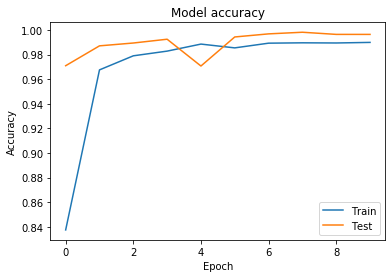

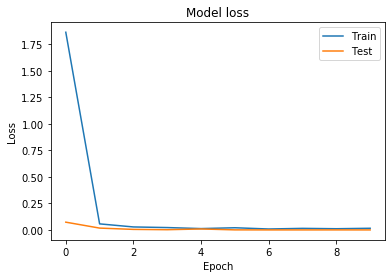

In [57]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.savefig(workDir + 'model_accuracy.png')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.savefig(workDir + 'model_loss.png')
plt.show()